In [6]:
# Cell 1: Load and process raw population density from .tif
import rasterio
import numpy as np
import geopandas as gpd
import pandas as pd

# Load the population density GeoTIFF
with rasterio.open("usa_pd_2020_1km_UNadj.tif") as src:
    pop_density = src.read(1)  # Read the first band (population density)
    pop_transform = src.transform  # Geospatial transform
    pop_crs = src.crs  # Coordinate reference system

# Load the cellular data with elevation and slope
cellular_data = gpd.read_file("cellular_data_with_slope.geojson")

# Function to get population density for a given lat/lon
def get_population_density(lat, lon, pop_density, transform):
    row, col = ~transform * (lon, lat)
    row, col = int(row), int(col)
    if 0 <= row < pop_density.shape[0] and 0 <= col < pop_density.shape[1]:
        return pop_density[row, col]
    else:
        return np.nan  # Return NaN for out-of-bounds coordinates

# Add raw population density to cellular data
cellular_data['raw_population_density'] = cellular_data.apply(
    lambda row: get_population_density(row.geometry.y, row.geometry.x, pop_density, pop_transform), axis=1
)

print(cellular_data.head())

# Drop rows with missing raw population density values
# cellular_data = cellular_data.dropna(subset=['raw_population_density'])

   FID  UniqSysID                     Licensee Callsign  LocNum  LatDeg  \
0   27      11510  AT&T Mobility Spectrum, LLC  KNKA679      12      47   
1   28      11510  AT&T Mobility Spectrum, LLC  KNKA679       6      47   
2   29      11510  AT&T Mobility Spectrum, LLC  KNKA679       7      47   
3   30      11510  AT&T Mobility Spectrum, LLC  KNKA679       8      47   
4   31      11510  AT&T Mobility Spectrum, LLC  KNKA679       9      47   

   LatMin  LatSec LatDir  LonDeg  ...  AllStruc  StrucType LicStatus  \
0      41     1.6      N     122  ...      12.8          B         A   
1      41    28.0      N     122  ...      45.4     MTOWER         A   
2      28    49.0      N     122  ...     128.9     GTOWER         A   
3      41    31.2      N     122  ...      50.9     MTOWER         A   
4      31     1.5      N     122  ...      47.8     MTOWER         A   

      latdec      londec                                                url  \
0  47.683778 -122.363583  http://wire

In [12]:
# Cell 1: Load and process raw population density from .tif
import rasterio
from rasterio.warp import transform as warp_transform  # Rename to avoid conflict
from rasterio.mask import mask
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import box

# Load the population density GeoTIFF
with rasterio.open("usa_pd_2020_1km_UNadj.tif") as src:
    # Read the first band (population density)
    pop_density = src.read(1)
    # Geospatial transform and CRS
    pop_transform = src.transform  # Affine transform
    pop_crs = src.crs
    # Get raster bounds
    raster_bounds = src.bounds

    # Load the cellular data with elevation and slope
    cellular_data = gpd.read_file("cellular_data_with_slope.geojson")

    # Check CRS of cellular_data and raster
    print("Cellular Data CRS:", cellular_data.crs)
    print("Raster CRS:", pop_crs)

    # If CRS is different, transform cellular_data to match the raster's CRS
    if cellular_data.crs != pop_crs:
        cellular_data = cellular_data.to_crs(pop_crs)

    # Check bounds of cellular_data and raster
    print("Raster Bounds:", raster_bounds)
    print("Cellular Data Bounds:", cellular_data.total_bounds)

    # Clip the raster to the bounds of cellular_data (optional, but recommended)
    bbox = box(*cellular_data.total_bounds)  # Create a bounding box
    out_image, out_transform = mask(src, [bbox], crop=True)  # Clip the raster
    pop_density = out_image[0]  # Update population density
    pop_transform = out_transform  # Update transform

# Function to get population density for a given lat/lon
def get_population_density(lat, lon, pop_density, transform, src_crs, target_crs):
    # Transform coordinates to the raster's CRS
    x, y = warp_transform(target_crs, src_crs, [lon], [lat])  # Use warp_transform
    row, col = ~transform * (x[0], y[0])  # Use the Affine transform
    row, col = int(row), int(col)
    if 0 <= row < pop_density.shape[0] and 0 <= col < pop_density.shape[1]:
        return pop_density[row, col]
    else:
        return np.nan  # Return NaN for out-of-bounds coordinates

# Add raw population density to cellular_data
cellular_data['raw_population_density'] = cellular_data.apply(
    lambda row: get_population_density(
        row.geometry.y, row.geometry.x, pop_density, pop_transform, cellular_data.crs, pop_crs
    ), axis=1
)

# Drop rows with missing raw population density values (optional)
# cellular_data = cellular_data.dropna(subset=['raw_population_density'])

# Print the updated cellular_data
print(cellular_data.head())

Cellular Data CRS: EPSG:4326
Raster CRS: EPSG:4326
Raster Bounds: BoundingBox(left=-179.15124930330558, bottom=18.90791676654655, right=179.78208259429442, top=71.39124988994655)
Cellular Data Bounds: [-124.66358333   28.34525    -100.00744444   49.00222222]
   FID  UniqSysID                     Licensee Callsign  LocNum  LatDeg  \
0   27      11510  AT&T Mobility Spectrum, LLC  KNKA679      12      47   
1   28      11510  AT&T Mobility Spectrum, LLC  KNKA679       6      47   
2   29      11510  AT&T Mobility Spectrum, LLC  KNKA679       7      47   
3   30      11510  AT&T Mobility Spectrum, LLC  KNKA679       8      47   
4   31      11510  AT&T Mobility Spectrum, LLC  KNKA679       9      47   

   LatMin  LatSec LatDir  LonDeg  ...  AllStruc  StrucType LicStatus  \
0      41     1.6      N     122  ...      12.8          B         A   
1      41    28.0      N     122  ...      45.4     MTOWER         A   
2      28    49.0      N     122  ...     128.9     GTOWER         A   
3 

In [7]:
print(cellular_data.crs)
print(pop_crs)

EPSG:4326
EPSG:4326


In [8]:
print(src.bounds)

BoundingBox(left=-179.15124930330558, bottom=18.90791676654655, right=179.78208259429442, top=71.39124988994655)


In [9]:
print(cellular_data.total_bounds)

[-124.66358333   28.34525    -100.00744444   49.00222222]


In [3]:
# # Cell 2: Load and process population-weighted density from .geojson
# # Load the population-weighted density GeoJSON
# us_population = gpd.read_file("us_population.geojson")

# # Use PWD_A (arithmetic mean) as the population-weighted density
# us_population['population_weighted_density'] = pd.to_numeric(us_population['PWD_A'], errors='coerce')

# # Ensure both datasets are in the same CRS
# if cellular_data.crs != us_population.crs:
#     us_population = us_population.to_crs(cellular_data.crs)

# # Check if 'index_right' exists in cellular_data or us_population
# if 'index_right' in cellular_data.columns:
#     cellular_data = cellular_data.drop(columns=['index_right'])
# if 'index_right' in us_population.columns:
#     us_population = us_population.drop(columns=['index_right'])

# # Spatial join to add population-weighted density to cellular data
# cellular_data = gpd.sjoin(cellular_data, us_population[['population_weighted_density', 'geometry']], how="left", predicate="within")

# # Drop rows with missing population-weighted density values
# # cellular_data = cellular_data.dropna(subset=['population_weighted_density'])

# # Check for multiple geometry columns and drop extras
# geometry_columns = [col for col in cellular_data.columns if isinstance(cellular_data[col], gpd.GeoSeries)]
# if len(geometry_columns) > 1:
#     # Drop all geometry columns except the primary 'geometry' column
#     columns_to_drop = [col for col in geometry_columns if col != 'geometry']
#     cellular_data = cellular_data.drop(columns=columns_to_drop)
# print(cellular_data[['population_weighted_density', 'geometry']].head())

# # Save the updated data (optional)
# cellular_data.to_file("cellular_data_with_population.geojson", driver="GeoJSON")

   population_weighted_density                     geometry
0                          NaN  POINT (-122.36358 47.68378)
1                          NaN  POINT (-122.71528 47.69111)
2                          NaN  POINT (-122.53389 47.48028)
3                          NaN    POINT (-122.82167 47.692)
4                          NaN  POINT (-122.57217 47.51708)


In [15]:
# Check bounds of cellular_data and us_population
print("Cellular Data Bounds:", cellular_data.total_bounds)
print("US Population Bounds:", us_population.total_bounds)

Cellular Data Bounds: [ 376690.27201383 3356317.91547789 2762613.91151871 5676448.00812821]
US Population Bounds: [3234259.18965274 4596883.09379876 3234259.18965274 4596883.09379876]


In [17]:
# Check CRS of both datasets
print("Cellular Data CRS:", cellular_data.crs)
print("US Population CRS:", us_population.crs)

Cellular Data CRS: EPSG:32610
US Population CRS: EPSG:32610


In [21]:
# Reload us_population
us_population = gpd.read_file("us_population.geojson")

# Check the columns
print("US Population Columns:", us_population.columns)

# Check the first few rows
print(us_population.head())

US Population Columns: Index(['lon', 'lat', 'year', 'ISO', 'ISO_No', 'Name', 'PWC_Lat', 'PWC_Lon',
       'Pop', 'Density',
       ...
       'PWD_P92', 'PWD_P93', 'PWD_P94', 'PWD_P95', 'PWD_P96', 'PWD_P97',
       'PWD_P98', 'PWD_P99', 'PWD_P100', 'geometry'],
      dtype='object', length=115)
       lon      lat  year  ISO ISO_No           Name  PWC_Lat   PWC_Lon  \
0 -92.4788  37.3172  2020  USA    840  United States  37.3172  -92.4788   

         Pop Density  ...  PWD_P92  PWD_P93  PWD_P94  PWD_P95  PWD_P96  \
0  331002647    36.1  ...  11054.1  12283.2  13841.5  15874.6  18744.1   

   PWD_P97  PWD_P98  PWD_P99  PWD_P100                  geometry  
0  23143.1  30722.0  47778.3  485077.8  POINT (-92.4788 37.3172)  

[1 rows x 115 columns]


In [18]:
# Reproject cellular_data to EPSG:4326
cellular_data = cellular_data.to_crs("EPSG:4326")

# Reproject us_population to EPSG:4326
us_population = us_population.to_crs("EPSG:4326")

# Check CRS of both datasets
print("Cellular Data CRS:", cellular_data.crs)
print("US Population CRS:", us_population.crs)

Cellular Data CRS: EPSG:4326
US Population CRS: EPSG:4326


In [22]:
# Convert PWD_A to numeric and create population_weighted_density column
us_population['population_weighted_density'] = pd.to_numeric(us_population['PWD_A'], errors='coerce')

# Check the result
print(us_population[['PWD_A', 'population_weighted_density']].head())

    PWD_A  population_weighted_density
0  4445.0                       4445.0


In [24]:
# load us_population
us_sub_population = gpd.read_file("us_sub_population.geojson")

# Check the columns
print("US subnat Population Columns:", us_sub_population.columns)

# Check the first few rows
print(us_sub_population.head())

US subnat Population Columns: Index(['lon', 'lat', 'year', 'ISO', 'ISO_No', 'Country_N', 'Adm_N', 'GID_1',
       'HASC', 'PWC_Lat', 'PWC_Lon', 'Pop', 'Density', 'Area', 'PWD_A',
       'PWD_G', 'PWD_M', 'PWD_D1', 'PWD_D2', 'PWD_D3', 'PWD_D4', 'PWD_D5',
       'PWD_D6', 'PWD_D7', 'PWD_D8', 'PWD_D9', 'PWD_D10', 'geometry'],
      dtype='object')
          lon        lat  year  ISO ISO_No      Country_N       Adm_N  \
0  -86.745407  33.015068  2020  USA    840  United States     Alabama   
1 -149.075200  61.505200  2020  USA    840  United States      Alaska   
2 -111.880226  33.363468  2020  USA    840  United States     Arizona   
3  -92.735825  35.205795  2020  USA    840  United States    Arkansas   
4 -119.334503  35.463676  2020  USA    840  United States  California   

     GID_1   HASC           PWC_Lat  ...  PWD_D2  PWD_D3  PWD_D4  PWD_D5  \
0  USA.1_1  US.AL  33.0150680541992  ...    84.6   179.5   341.5   582.0   
1  USA.2_1  US.AK           61.5052  ...   156.5   340.6   652

In [25]:
# Reproject cellular_data to EPSG:4326
cellular_data = cellular_data.to_crs("EPSG:4326")

# Reproject us_population to EPSG:4326
us_population = us_population.to_crs("EPSG:4326")

# Check CRS of both datasets
print("Cellular Data CRS:", cellular_data.crs)
print("US Population CRS:", us_population.crs)

Cellular Data CRS: EPSG:4326
US Population CRS: EPSG:4326


In [26]:
# Convert PWD_A to numeric and create population_weighted_density column
us_sub_population['population_weighted_density_sub'] = pd.to_numeric(us_sub_population['PWD_A'], errors='coerce')

# Check the result
print(us_sub_population[['PWD_A', 'population_weighted_density_sub']].head())

    PWD_A  population_weighted_density_sub
0  1403.5                           1403.5
1  2476.7                           2476.7
2  4544.3                           4544.3
3  1551.4                           1551.4
4  6174.3                           6174.3


In [56]:
# Drop 'index_right' if it exists in either dataset
if 'index_right' in cellular_data.columns:
    cellular_data = cellular_data.drop(columns=['index_right'])
if 'index_right' in us_sub_population.columns:
    us_sub_population = us_sub_population.drop(columns=['index_right'])

In [57]:
# Reproject cellular_data to a projected CRS (e.g., UTM zone 10N for the US)
cellular_data = cellular_data.to_crs("EPSG:32610")

# Reproject us_sub_population to the same projected CRS
us_sub_population = us_sub_population.to_crs("EPSG:32610")

# Check CRS of both datasets
print("Cellular Data CRS:", cellular_data.crs)
print("US Subnat Population CRS:", us_sub_population.crs)

Cellular Data CRS: EPSG:32610
US Subnat Population CRS: EPSG:32610


In [58]:
# Perform a nearest join
cellular_data = gpd.sjoin_nearest(
    cellular_data,
    us_sub_population[['population_weighted_density_sub', 'geometry']],
    how="left"
)

# Check the result
print(cellular_data[['population_weighted_density_sub', 'geometry']].head())

   population_weighted_density_sub  \
0                           3391.5   
1                           3391.5   
2                           3391.5   
3                           3391.5   
4                           3391.5   

                                            geometry  
0  POLYGON ((548513.619 5281356.776, 548510.914 5...  
1  POLYGON ((522115.859 5282011.5, 522112.66 5281...  
2  POLYGON ((535870.952 5258647.735, 535867.991 5...  
3  POLYGON ((514132.235 5282085.403, 514128.886 5...  
4  POLYGON ((532964.004 5262721.197, 532960.993 5...  


In [61]:
# Drop all duplicate columns except for 'population_weighted_density_sub'
columns_to_drop = [
    col for col in cellular_data.columns 
    if col.startswith('population_weighted_density_sub') and col != 'population_weighted_density_sub'
]
cellular_data = cellular_data.drop(columns=columns_to_drop)

# Check if multiple 'population_weighted_density_sub' columns exist
population_density_cols = [col for col in cellular_data.columns if col == 'population_weighted_density_sub']
if len(population_density_cols) > 1:
    # Keep the first occurrence and drop the rest
    columns_to_drop = population_density_cols[1:]
    cellular_data = cellular_data.drop(columns=columns_to_drop)

# Check the columns again
print("Columns after ensuring one population_weighted_density_sub:", cellular_data.columns)

# Save the updated GeoDataFrame
cellular_data.to_file("cellular_data_with_population.geojson", driver="GeoJSON")

Columns after ensuring one population_weighted_density_sub: Index(['FID', 'UniqSysID', 'Licensee', 'Callsign', 'LocNum', 'LatDeg',
       'LatMin', 'LatSec', 'LatDir', 'LonDeg', 'LonMin', 'LonSec', 'LonDir',
       'LocAdd', 'LocCity', 'LocCounty', 'LocState', 'Nepa', 'QZone', 'TowReg',
       'SupStruc', 'AllStruc', 'StrucType', 'LicStatus', 'latdec', 'londec',
       'url', 'elevation', 'slope', 'geometry', 'raw_population_density',
       'population_weighted_density_left', 'population_weighted_density_right',
       'Adm_N_left', 'Adm_N_right', 'index_right',
       'population_weighted_density_sub'],
      dtype='object')


In [38]:
# Check the number of unique points in us_sub_population
print("Number of unique points in us_sub_population:", us_sub_population.shape[0])

# Check unique values in population_weighted_density_sub
print("Unique population_weighted_density_sub values:", us_sub_population['population_weighted_density_sub'].unique())

Number of unique points in us_sub_population: 50
Unique population_weighted_density_sub values: [ 1403.5  2476.7  4544.3  1551.4  6174.3  3953.   3041.4  3315.   3722.6
  2002.9  7874.   2522.8  5357.9  2203.   2090.9  2199.2  1746.7  1985.1
  1206.1  5452.6  5206.5  2031.1  2466.6  1410.9  2093.7  1697.5  2850.
  6290.   1657.4  6072.1  2567.6 16837.7  1721.   2490.2  2173.9  2277.3
  3464.   4150.9  3963.2  1575.3  1988.5  1710.2  4387.2  3982.8  1283.9
  3966.3  3391.5  1543.2  2470.6  2222. ]


In [62]:
import geopandas as gpd

# Load the GeoJSON files
a_block = gpd.read_file("A_Block_CGSA.geojson")
b_block = gpd.read_file("B_Block_CGSA.geojson")

# Check the data
print(a_block.head())
print(b_block.head())

  DATE_CREAT  VERSION  MARKET DATE_GRANT    FILE_NUM   ULS_ID CALL_SIGN BLOCK  \
0 2011-08-23  Current  CMA344 2002-05-21  0000810807  1116748   KNKN260     A   
1 2011-07-15  Current  CMA252 2011-02-18  0004434164  5773025   KNKA802     A   
2 2011-07-15  Current  CMA252 2011-02-18  0004434164  5773025   KNKA802     A   
3 2011-09-28  Current  CMA463 2004-12-29  0001980738  2690709   KNKN659     A   
4 2011-08-24  Current  CMA514 2004-05-13  0001592587  2430688   KNKQ450     A   

        AsOf                                           geometry  
0 2014-01-09  POLYGON ((-123.54362 38.77622, -123.54589 38.7...  
1 2014-01-09  POLYGON ((-88.88832 30.24044, -88.88827 30.240...  
2 2014-01-09  POLYGON ((-88.4123 30.73246, -88.41171 30.7173...  
3 2014-01-09  POLYGON ((-70.5206 45.56077, -70.50623 45.5137...  
4 2014-01-09  MULTIPOLYGON (((-92.21017 38.01685, -92.21001 ...  
  DATE_CREAT  VERSION  MARKET DATE_GRANT    FILE_NUM   ULS_ID CALL_SIGN BLOCK  \
0 2011-11-21  Current  CMA570 2010-0

In [63]:
import matplotlib.pyplot as plt

# Plot the CGSAs
all_cgsas_projected.plot(color='lightblue', edgecolor='black', figsize=(10, 10))

# Plot the points
cellular_data_projected.plot(ax=plt.gca(), color='red', markersize=5)

plt.title("Points and CGSAs in Projected CRS")
plt.show()

NameError: name 'all_cgsas_projected' is not defined

In [19]:
# Check for invalid geometries in all_cgsas_projected
invalid_geometries = all_cgsas_projected[~all_cgsas_projected.geometry.is_valid]
print("Invalid geometries found:", len(invalid_geometries))

Invalid geometries found: 138


In [20]:
print(invalid_geometries)

     DATE_CREAT  VERSION  MARKET DATE_GRANT    FILE_NUM   ULS_ID CALL_SIGN  \
3    2011-09-28  Current  CMA463 2004-12-29  0001980738  2690709   KNKN659   
22   2011-08-01  Current  CMA172 2009-08-24  0003652403  5057766   KNKA784   
40   2011-11-16  Current  CMA535 2002-09-14  0001028369  1472357   KNKN444   
98   2012-01-19  Current  CMA511 2012-01-30  0004952484  6457627   KNKN377   
152  2012-03-22  Current  CMA641 2012-05-15  0004941659  6693916   KNKN272   
...         ...      ...     ...        ...         ...      ...       ...   
2138 2013-11-06  Pending  CMA146        NaT  0006003844  7939534   KNKA703   
2150 2013-11-12  Pending  CMA364        NaT  0006010468  7947270   KNKQ335   
2200 2013-12-05  Current  CMA313 2013-12-06  0005923795  7967637   KNKN725   
2216 2013-12-09  Pending  CMA117        NaT  0006047957  8000454   KNKA371   
2243 2014-01-07  Pending  CMA005        NaT  0005903074  8050709   KNKA231   

     BLOCK       AsOf                                          

In [21]:
# Fix invalid geometries using buffer(0)
all_cgsas_projected.geometry = all_cgsas_projected.geometry.buffer(0)

In [22]:
invalid_geometries = all_cgsas_projected[~all_cgsas_projected.geometry.is_valid]
print("Invalid geometries after fixing:", len(invalid_geometries))

Invalid geometries after fixing: 0


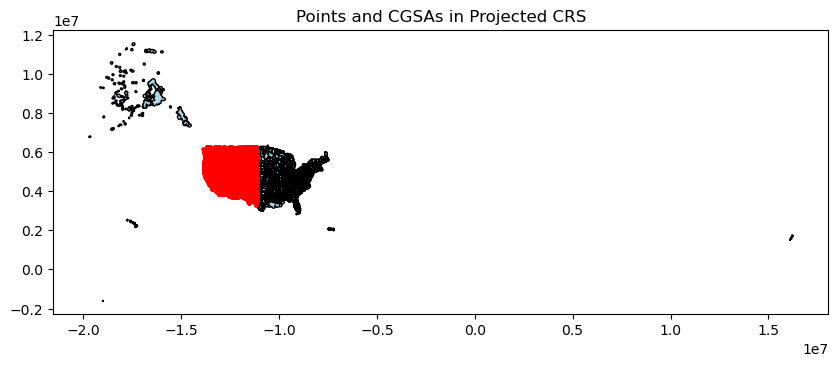

In [24]:
# Visualize the points and CGSAs
import matplotlib.pyplot as plt

# Plot the CGSAs
all_cgsas_projected.plot(color='lightblue', edgecolor='black', figsize=(10, 10))

# Plot the points
cellular_data_projected.plot(ax=plt.gca(), color='red', markersize=5)

plt.title("Points and CGSAs in Projected CRS")
plt.show()

In [25]:
from shapely.geometry import Polygon

# Create a boundary for the CGSAs
all_cgsas_boundary = all_cgsas_projected.geometry.boundary

# Function to calculate distance to nearest CGSA boundary
def distance_to_nearest_cgsa_boundary(point, boundaries):
    return boundaries.distance(point).min()

# Add distance to nearest CGSA boundary as a feature (in meters)
cellular_data['distance_to_nearest_cgsa_boundary_meters'] = cellular_data_projected.geometry.apply(
    lambda point: distance_to_nearest_cgsa_boundary(point, all_cgsas_boundary))

# Convert distances to kilometers
cellular_data['distance_to_nearest_cgsa_boundary_km'] = cellular_data['distance_to_nearest_cgsa_boundary_meters'] / 1000

# Check the updated cellular_data
print(cellular_data[['geometry', 'distance_to_nearest_cgsa_boundary_meters', 'distance_to_nearest_cgsa_boundary_km']].head())

                      geometry  distance_to_nearest_cgsa_boundary_meters  \
0  POINT (-122.36358 47.68378)                               4346.860883   
1  POINT (-122.71528 47.69111)                               3321.062695   
2  POINT (-122.53389 47.48028)                               1350.991269   
3    POINT (-122.82167 47.692)                                751.277536   
4  POINT (-122.57217 47.51708)                               3072.048010   

   distance_to_nearest_cgsa_boundary_km  
0                              4.346861  
1                              3.321063  
2                              1.350991  
3                              0.751278  
4                              3.072048  


In [64]:
import geopandas as gpd
from shapely.geometry import Point

# Combine A and B Block CGSAs into a single GeoDataFrame
all_cgsas = gpd.GeoDataFrame(pd.concat([a_block, b_block], ignore_index=True))

# Load your cellular data
cellular_data = gpd.read_file("cellular_data_with_population.geojson")

# Ensure all data is in EPSG:4326
cellular_data = cellular_data.to_crs("EPSG:4326")
all_cgsas = all_cgsas.to_crs("EPSG:4326")

# Temporarily reproject to a projected CRS (e.g., EPSG:3857) for distance calculations
projected_crs = "EPSG:3857"  # Web Mercator (units in meters)
cellular_data_projected = cellular_data.to_crs(projected_crs)
all_cgsas_projected = all_cgsas.to_crs(projected_crs)

# Calculate centroids of CGSAs (approximate cell tower locations)
all_cgsas_projected['centroid'] = all_cgsas_projected.geometry.centroid

# Function to calculate distance to nearest cell tower (CGSA centroid)
def distance_to_nearest_tower(point, towers):
    return towers.distance(point).min()

# Add distance to nearest cell tower as a feature (in meters)
cellular_data['distance_to_nearest_tower_meters'] = cellular_data_projected.geometry.apply(
    lambda point: distance_to_nearest_tower(point, all_cgsas_projected['centroid']))

# Convert distances to kilometers
cellular_data['distance_to_nearest_tower_km'] = cellular_data['distance_to_nearest_tower_meters'] / 1000

# Check the updated cellular_data
print(cellular_data[['geometry', 'distance_to_nearest_tower_meters', 'distance_to_nearest_tower_km']].head())

# Save the updated data
cellular_data.to_file("cellular_data_with_tower_distance.geojson", driver="GeoJSON")

                                            geometry  \
0  POLYGON ((-122.35358 47.68378, -122.35363 47.6...   
1  POLYGON ((-122.70528 47.69111, -122.70533 47.6...   
2  POLYGON ((-122.52389 47.48028, -122.52394 47.4...   
3  POLYGON ((-122.81167 47.692, -122.81171 47.691...   
4  POLYGON ((-122.56217 47.51708, -122.56221 47.5...   

   distance_to_nearest_tower_meters  distance_to_nearest_tower_km  
0                      29609.666168                     29.609666  
1                      10698.982082                     10.698982  
2                      25458.599057                     25.458599  
3                      19560.462769                     19.560463  
4                      18049.817908                     18.049818  


In [65]:
import geopandas as gpd
from shapely.validation import make_valid

# Combine A and B Block CGSAs into a single GeoDataFrame
all_cgsas = gpd.GeoDataFrame(pd.concat([a_block, b_block], ignore_index=True))

# Load your cellular data
cellular_data = gpd.read_file("cellular_data_with_population.geojson")

# Ensure all data is in EPSG:4326
cellular_data = cellular_data.to_crs("EPSG:4326")
all_cgsas = all_cgsas.to_crs("EPSG:4326")

# Check for multiple geometry columns and drop extras
geometry_columns = [col for col in cellular_data.columns if isinstance(cellular_data[col], gpd.GeoSeries)]
if len(geometry_columns) > 1:
    # Drop all geometry columns except the primary 'geometry' column
    columns_to_drop = [col for col in geometry_columns if col != 'geometry']
    cellular_data = cellular_data.drop(columns=columns_to_drop)

# Temporarily reproject to a projected CRS (e.g., EPSG:3857) for distance calculations
projected_crs = "EPSG:3857"  # Web Mercator (units in meters)
cellular_data_projected = cellular_data.to_crs(projected_crs)
all_cgsas_projected = all_cgsas.to_crs(projected_crs)

# Verify reprojection
print("Cellular Data CRS:", cellular_data_projected.crs)
print("All CGSAs CRS:", all_cgsas_projected.crs)

# Check for invalid geometries in all_cgsas_projected
invalid_geometries = all_cgsas_projected[~all_cgsas_projected.geometry.is_valid]
print("Invalid geometries found:", len(invalid_geometries))

# Fix invalid geometries using buffer(0)
all_cgsas_projected.geometry = all_cgsas_projected.geometry.buffer(0)

# Re-check for invalid geometries
invalid_geometries = all_cgsas_projected[~all_cgsas_projected.geometry.is_valid]
print("Invalid geometries after buffer(0):", len(invalid_geometries))

# If there are still invalid geometries, use make_valid
if len(invalid_geometries) > 0:
    all_cgsas_projected.geometry = all_cgsas_projected.geometry.apply(
        lambda geom: make_valid(geom) if not geom.is_valid else geom
    )

# Re-check for invalid geometries
invalid_geometries = all_cgsas_projected[~all_cgsas_projected.geometry.is_valid]
print("Invalid geometries after make_valid:", len(invalid_geometries))

# If there are still invalid geometries, drop them
if len(invalid_geometries) > 0:
    print("Dropping remaining invalid geometries.")
    all_cgsas_projected = all_cgsas_projected[all_cgsas_projected.geometry.is_valid]

# Check if any points fall within the CGSAs
points_within_cgsas = cellular_data_projected.geometry.within(all_cgsas_projected.unary_union)
print("Points within CGSAs:", points_within_cgsas.sum())

# Calculate centroids of CGSAs (approximate cell tower locations)
all_cgsas_projected['centroid'] = all_cgsas_projected.geometry.centroid

# Function to calculate distance to nearest cell tower (CGSA centroid)
def distance_to_nearest_tower(point, towers):
    return towers.distance(point).min()

# Add distance to nearest cell tower as a feature (in meters)
cellular_data['distance_to_nearest_tower_meters'] = cellular_data_projected.geometry.apply(
    lambda point: distance_to_nearest_tower(point, all_cgsas_projected['centroid']))

# Convert distances to kilometers
cellular_data['distance_to_nearest_tower_km'] = cellular_data['distance_to_nearest_tower_meters'] / 1000

# Check the updated cellular_data
print(cellular_data[['geometry', 'distance_to_nearest_tower_meters', 'distance_to_nearest_tower_km']].head())

# Save the updated data
cellular_data.to_file("cellular_data_with_cgsa_distance.geojson", driver="GeoJSON")

Cellular Data CRS: EPSG:3857
All CGSAs CRS: EPSG:3857
Invalid geometries found: 138
Invalid geometries after buffer(0): 0
Invalid geometries after make_valid: 0


/tmp/ipykernel_2559/2337266770.py:57: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  points_within_cgsas = cellular_data_projected.geometry.within(all_cgsas_projected.unary_union)


Points within CGSAs: 5728
                                            geometry  \
0  POLYGON ((-122.35358 47.68378, -122.35363 47.6...   
1  POLYGON ((-122.70528 47.69111, -122.70533 47.6...   
2  POLYGON ((-122.52389 47.48028, -122.52394 47.4...   
3  POLYGON ((-122.81167 47.692, -122.81171 47.691...   
4  POLYGON ((-122.56217 47.51708, -122.56221 47.5...   

   distance_to_nearest_tower_meters  distance_to_nearest_tower_km  
0                      29609.666168                     29.609666  
1                      10698.982082                     10.698982  
2                      25458.599057                     25.458599  
3                      19560.462769                     19.560463  
4                      18049.817908                     18.049818  
